In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import warnings


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

#avoid warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../dataset/preprocessed_data/preprocessed_df.csv')

In [3]:
df

,Unnamed: 0,transmission,ownerno,original_equipment_manufacturer,model,drive_modes,voice_control,smart_key_band,battery_saver,rear_reading_lamp,...,no_of_cylinder_6.0,no_of_cylinder_7.0,no_of_cylinder_8.0,tyre_type_None/other,tyre_type_radial,tyre_type_radial_runflat,tyre_type_runflat,tyre_type_runflat_tubeless,tyre_type_tubeless,tyre_type_tubeless_radial
0,0,0,1,-0.031819,-0.031912,True,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
1,1,1,2,-0.028797,-0.033061,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
2,2,0,1,-0.024820,-0.019402,True,True,False,False,True,...,0,0,0,0,0,0,0,0,0,1
3,3,1,2,0.047078,-0.035159,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
4,4,1,1,-0.028797,-0.033061,False,False,False,True,False,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,8364,1,2,-0.032443,-0.029565,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,1
8365,8365,1,2,0.047078,-0.036246,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
8366,8366,1,2,-0.020066,-0.035747,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
8367,8367,1,1,-0.028797,-0.034953,False,False,False,True,False,...,0,0,0,0,0,0,0,0,1,0


In [4]:

SEED = 42

y = df['price']
X = df.drop('price',axis=1)


x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.10, random_state=SEED,shuffle= True)


print("X_train : ",x_train.shape)
print("y_train : ",y_train.shape)

print("X_test : ",x_test.shape)
print("y_test : ",y_test.shape)

#deleting unused variables
del X,y

X_train :  (7532, 226)
y_train :  (7532,)
X_test :  (837, 226)
y_test :  (837,)


### Model - 1

In [5]:
svm = SVR()


#fitting whole x_train
svm.fit(x_train,y_train)

train_prediction = svm.predict(x_train)
test_prediction = svm.predict(x_test)

#calculating RMSE score
train_rmse = np.sqrt(mean_squared_error(y_train,train_prediction))
test_rmse = np.sqrt(mean_squared_error(y_test,test_prediction))

In [6]:
print(train_rmse)
print(test_rmse)

1.0556980933332067
0.09672037757487204


<Axes: >

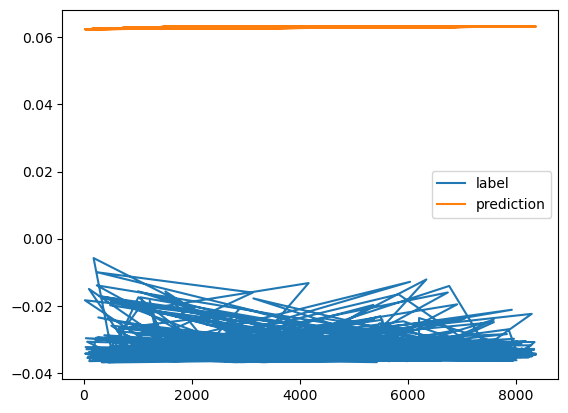

In [12]:
#plotting graph predicted vs actual target
svm_test_results = pd.DataFrame()
svm_test_results['label'] = y_test
svm_test_results['prediction'] = test_prediction

svm_test_results.plot()

### Model 2 - Random forest

In [15]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
forest_grid = RandomForestRegressor()

forest_hyper_param = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
    'max_depth' : [int(x) for x in np.linspace(3, 80, num = 11)],
    'min_samples_split' : [2, 3, 5],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap': [True,False]
}

forest_random_search = RandomizedSearchCV(estimator = forest_grid , param_distributions = forest_hyper_param, n_iter = 100, cv = 5, verbose=1, random_state=SEED , n_jobs = -1)

# Fit the Algorithm 
forest_random_search.fit(x_train, y_train)
print("------ BEST PARAMETER -----", forest_random_search.best_params_)
print("------ BEST ESTIMATOR -----" , forest_random_search.best_estimator_)

----- BEST PARAMETER ----- {'n_estimators': 166, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 41, 'bootstrap': True}
------ BEST ESTIMATOR ----- RandomForestRegressor(max_depth=41, n_estimators=166)


In [16]:
random_forst = forest_random_search.best_estimator_

random_forst.fit(x_train,y_train)

# Predict on the model
for_train_prediction = random_forst.predict(x_train)
for_test_prediction = random_forst.predict(x_test)

#calculating RMSE score
train_rmse = np.sqrt(mean_squared_error(y_train,for_train_prediction))
test_rmse = np.sqrt(mean_squared_error(y_test,for_test_prediction))

In [17]:
#printing RMSE score
print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  0.3793027365505076
Test RMSE:  0.2773567761544332


<Axes: >

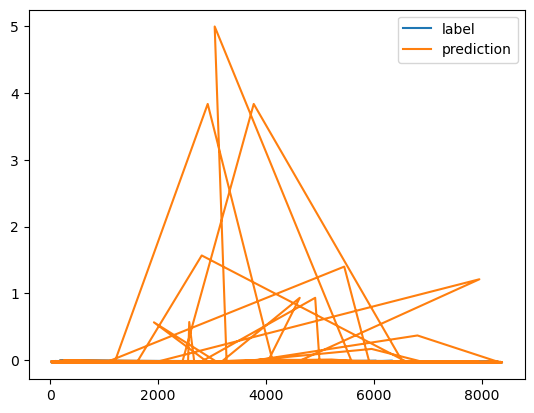

In [18]:
#plotting graph predicted vs actual target
random_for_results = pd.DataFrame()
random_for_results['label'] = y_test
random_for_results['prediction'] = for_test_prediction

random_for_results.plot()

### Model 3 - XG Boost

In [19]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
xgb_grid = XGBRegressor(eval_metric = 'rmse')

xgb_params = {
 'max_depth': [5,8,9,12],
 'min_child_weight': [1,2,3],
 'learning_rate': [0.1,0.01,0.15],
  'n_estimators': [60,80,100,140,160]
}

xgb_grid_search = GridSearchCV(xgb_grid, xgb_params, cv=5,
                               scoring='neg_root_mean_squared_error',
                         )

xgb_grid_search.fit(x_train, y_train)
print("------ BEST PARAMETER -----", xgb_grid_search.best_params_)
print("------ BEST ESTIMATOR -----" , xgb_grid_search.best_estimator_)


------ BEST PARAMETER ----- {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 60}
------ BEST ESTIMATOR ----- XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [20]:
# Fit the Algorithm
xgb_grid = xgb_grid_search.best_estimator_

xgb_grid.fit(x_train,y_train)

# Predict on the model
xgb_train_prediction = xgb_grid.predict(x_train)
xgb_test_prediction = xgb_grid.predict(x_test)

#calculating RMSE score
train_rmse = np.sqrt(mean_squared_error(y_train,xgb_train_prediction))
test_rmse = np.sqrt(mean_squared_error(y_test,xgb_test_prediction))

In [21]:
print(train_rmse)
print(test_rmse)

0.8163526558312764
0.1682288222176095


<Axes: >

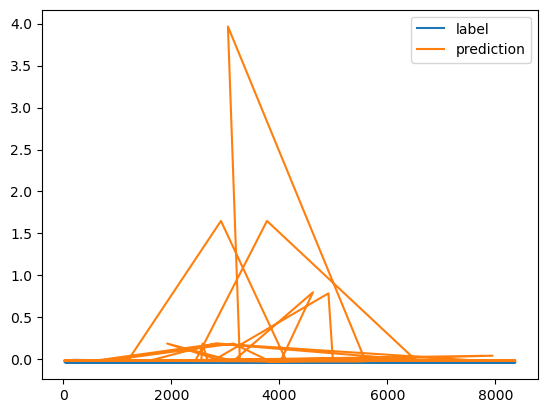

In [22]:
#plotting graph predicted vs actual target
xgb_test_results = pd.DataFrame()
xgb_test_results['label'] = y_test
xgb_test_results['prediction'] = xgb_test_prediction
xgb_test_results.plot()